In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import PercentFormatter

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from IPython.display import display, HTML, display_html

## часть 1. исследование данных

In [20]:
data = pd.read_csv('data.csv', sep=';')
data.head()

,Номер варианта,ID,INCOME_BASE_TYPE,CREDIT_PURPOSE,INSURANCE_FLAG,DTI,SEX,FULL_AGE_CHILD_NUMBER,DEPENDANT_NUMBER,EDUCATION,...,own_closed,min_MnthAfterLoan,max_MnthAfterLoan,dlq_exist,thirty_in_a_year,sixty_in_a_year,ninety_in_a_year,thirty_vintage,sixty_vintage,ninety_vintage
0,5,1000005,Поступление зарплаты на счет,Покупка недвижимости/ строительство,1,0.26,мужской,0,0,среднее,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,1000025,Поступление зарплаты на счет,Покупка автомобиля,1,0.45,мужской,1,0,высшее,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,1000045,2НДФЛ,Ремонт,1,0.49,мужской,0,0,высшее,...,0.0,66.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,1000065,Форма банка (без печати работодателя),Ремонт,1,0.38,мужской,1,0,Высшее/Второе высшее/Ученая степень,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1000085,Поступление зарплаты на счет,Ремонт,0,0.16,мужской,1,0,высшее,...,0.0,49.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


сразу заметим, что столбец "номер варианта" можно удалить, потому что это никак не характризует наши данные

In [21]:
data.drop(columns=['Номер варианта'], inplace=True)

теперь по [описанию признаков](https://docs.yandex.ru/docs/view?url=ya-disk-public%3A%2F%2Fi%2FfCz9oIxedlBoPvvEHViJerzhVa17o161QfiiZa6880kEitZ%2B9RUOkW2UiV5uoVq%2FJ6bpmRyOJonT3VoXnDag%3D%3D%3A%2F%D0%9E%D0%BF%D0%B8%D1%81%D0%B0%D0%BD%D0%B8%D0%B5%20%D0%BF%D0%B0%D1%80%D0%B0%D0%BC%D0%B5%D1%82%D1%80%D0%BE%D0%B2_Description%20of%20parameters_sas_2022_hw1.csv&name=%D0%9E%D0%BF%D0%B8%D1%81%D0%B0%D0%BD%D0%B8%D0%B5%20%D0%BF%D0%B0%D1%80%D0%B0%D0%BC%D0%B5%D1%82%D1%80%D0%BE%D0%B2_Description%20of%20parameters_sas_2022_hw1.csv&nosw=1) разделю столбцы на категориальные и числовые признаки, чтобы было удобнее дальше интерпретировать данные

In [22]:
categorical = ['CREDIT_PURPOSE', 'EDUCATION', 'EMPL_TYPE', 'EMPL_FORM', 'FAMILY_STATUS', 
               'EMPL_PROPERTY', 'INCOME_BASE_TYPE', 'BANKACCOUNT_FLAG', 'EMPL_SIZE', 'INSURANCE_FLAG', 'SEX', 
               'if_zalog', 'dlq_exist', 'thirty_in_a_year', 'sixty_in_a_year', 
               'ninety_in_a_year', 'thirty_vintage', 'sixty_vintage', 'ninety_vintage']

numerical = ['DTI', 'FULL_AGE_CHILD_NUMBER', 'DEPENDANT_NUMBER', 'Period_at_work', 
             'age', 'max90days', 'max60days', 'max30days', 'max21days', 'max14days', 
             'avg_num_delay', 'num_AccountActive180', 'num_AccountActive90', 'num_AccountActive60', 
             'Active_to_All_prc', 'numAccountActiveAll', 'numAccountClosed', 'sum_of_paym_months', 
             'all_credits', 'Active_not_cc', 'own_closed', 'min_MnthAfterLoan', 'max_MnthAfterLoan']

# проверка, что нет пересечений в списках
assert(len(list(set(categorical) & set(numerical))) == 0)

print('количество категориальных признаков:', len(categorical), '\nколичество числовых признаков:', len(numerical))

количество категориальных признаков: 19 
количество числовых признаков: 23


но заметим, что ID я пропустила, так как его можно записать в любую из категорий признаков

In [23]:
# функция для подсчета статистик по уникальным значениям, нулям и пропускам 
def count_values_stats(df, flag, initial_rows=None):
    no_nans = []
    nans = []

    rows = df.shape[0]

    types = ['categorical', 'numerical']
    stats = pd.DataFrame(columns=['category type', 'data type', 'unique values', 'unique %',
                                  'null value', 'null %', 'nan value', 'nan %'])

    for column in df.columns:
        unique = len(df[column].unique())
        unique_percent = unique / rows * 100
        
        nan = df[column].isna().sum()
        nan_percent = nan / rows * 100
        
        zeros = (df[column] == 0).sum()
        zeros_percent = zeros / rows * 100
        
        stats.loc[column] = [
            types[(column in numerical)],
            df[column].dtype,
            unique, unique_percent,
            zeros, zeros_percent,
            nan, nan_percent
        ]
        
        if column == 'ID':
            stats.loc[column, 'category type'] = '-'
            
        else:    
            if nan_percent == 0:
                no_nans.append(column)
            else:
                nans.append(column)
    
    if flag:
        print('total rows dropped:', initial_rows - rows)
    display(stats)
    
    return stats, no_nans, nans

In [24]:
initial_rows = data.shape[0]
initial, _, _ = count_values_stats(data, False)

,category type,data type,unique values,unique %,null value,null %,nan value,nan %
ID,-,int64,10243,100.000000,0,0.000000,0,0.000000
INCOME_BASE_TYPE,categorical,object,5,0.048814,0,0.000000,57,0.556478
CREDIT_PURPOSE,categorical,object,10,0.097628,0,0.000000,0,0.000000
INSURANCE_FLAG,categorical,int64,2,0.019526,4104,40.066387,0,0.000000
DTI,numerical,float64,62,0.605291,1,0.009763,122,1.191057
SEX,categorical,object,2,0.019526,0,0.000000,0,0.000000
FULL_AGE_CHILD_NUMBER,numerical,int64,7,0.068339,6154,60.080055,0,0.000000
DEPENDANT_NUMBER,numerical,int64,3,0.029288,10214,99.716880,0,0.000000
EDUCATION,categorical,object,9,0.087865,0,0.000000,0,0.000000
EMPL_TYPE,categorical,object,10,0.097628,0,0.000000,9,0.087865


по полученной табличке можем сделать несколько выводов:

- столбец ID состоит исключительно из уникальных значений, нет пропусков и нулей. это классно, значит, у нас корректные данные, нет ошибок. но при этом его можно удалить, потому что он никак не характеризует клиента и добавлять этот признак в дальнейшую аналитику или сегментацию нет смысла

- у остальных признаков очень мало уникальных значений. у категориальных признаков в среднем до 0.1% уникальных данных, что адекватно и логично. но у числовых признаков тоже колеблется от менее 0.1% до максимально почти 11% в avg_num_delay. пока что сложно это интерпретировать

- очень много нулей в столбце DEPENDANT_NUMBER, больше 99 процентов. практически ни у кого нет иждивенцев

- практически все признаки имеют тип float64. возможно, стоит в категориальных признаках поменять тип на int, чтобы тратить меньше памяти. но в целом, кажется, это непринципиальный момент. а еще строки в категориальных питон воспринимает как объекты, но, кажется, это тоже не проблема

- у большей части признаков доля значений NaN превышает 61%. а, начиная с признака if_zalog, количество пропусков стабильно сохраняется на уровне 6567. вероятно, это обратившиеся-не клиенты банка, поэтому таких закрытых данных, как количество активных счетов счетов за последнее время, у нас нет. запомним этот факт и эту цифру. думаю, можно сразу их удалить, а уже дальше смотреть на данные, чтобы не клиенты нам не мешали

посчитаем статистики минимума, максимума и тд до чистки 6к пропусков и после, чтобы сравнить данные

In [25]:
# функция для подсчета статистик: минимума, максимума, среднего, стандартного отклонения и медианы
def count_numeric_stats(df):
    stats =  pd.DataFrame(columns=['min', 'max', 'mean', 'standart deviation', 'median'])
    for column in df.columns:
        if column in numerical:
                stats.loc[column] = [
                    df[column].min(),
                    df[column].max(),
                    df[column].mean(),
                    df[column].std(),
                    df[column].median()
                ]
    return stats

initial_numeric_stats = count_numeric_stats(data)
initial_numeric_stats

,min,max,mean,standart deviation,median
DTI,0.0,0.6,0.385248,0.135915,0.400000
FULL_AGE_CHILD_NUMBER,0.0,14.0,0.554330,0.785071,0.000000
DEPENDANT_NUMBER,0.0,2.0,0.003710,0.073851,0.000000
Period_at_work,6.0,966.0,66.374479,67.465261,45.000000
age,23.0,62.0,36.324751,8.612645,35.000000
max90days,0.0,18.0,1.585820,1.878678,1.000000
max60days,0.0,18.0,1.140780,1.593697,1.000000
max30days,0.0,15.0,0.850548,1.328305,0.000000
max21days,0.0,15.0,0.635297,1.158869,0.000000
max14days,0.0,15.0,0.523591,1.036584,0.000000


чистим данные от пропусков

In [26]:
rows_to_drop = (initial['category type'] == 'categorical') & (initial['nan value'] == 6567)
data.dropna(subset=data.columns[rows_to_drop], inplace=True)

_, no_nans, nans = count_values_stats(data, True, initial_rows)

total rows dropped: 6567


,category type,data type,unique values,unique %,null value,null %,nan value,nan %
ID,-,int64,3676,100.000000,0,0.000000,0,0.000000
INCOME_BASE_TYPE,categorical,object,4,0.108814,0,0.000000,0,0.000000
CREDIT_PURPOSE,categorical,object,10,0.272035,0,0.000000,0,0.000000
INSURANCE_FLAG,categorical,int64,2,0.054407,1430,38.900979,0,0.000000
DTI,numerical,float64,59,1.605005,0,0.000000,0,0.000000
SEX,categorical,object,2,0.054407,0,0.000000,0,0.000000
FULL_AGE_CHILD_NUMBER,numerical,int64,7,0.190424,2261,61.507073,0,0.000000
DEPENDANT_NUMBER,numerical,int64,3,0.081610,3667,99.755169,0,0.000000
EDUCATION,categorical,object,8,0.217628,0,0.000000,0,0.000000
EMPL_TYPE,categorical,object,9,0.244831,0,0.000000,0,0.000000


заметим, что мы пока что удалили только строчки, для которых NaN'ы были лишь в категориальных признаках после if_zalog, но при этом NaN'ы полностью ушли и из всех остальных категорий

посмотрим теперь, как изменились числовые признаки после чистки?

In [27]:
after_drop_numeric_stats = count_numeric_stats(data)

display_html(initial_numeric_stats.style.set_table_attributes("style='display:inline'")._repr_html_() +
             after_drop_numeric_stats.style.set_table_attributes("style='display:inline'")._repr_html_(), raw=True)

,min,max,mean,standart deviation,median
DTI,0.000000,0.600000,0.385248,0.135915,0.400000
FULL_AGE_CHILD_NUMBER,0.000000,14.000000,0.554330,0.785071,0.000000
DEPENDANT_NUMBER,0.000000,2.000000,0.003710,0.073851,0.000000
Period_at_work,6.000000,966.000000,66.374479,67.465261,45.000000
age,23.000000,62.000000,36.324751,8.612645,35.000000
max90days,0.000000,18.000000,1.585820,1.878678,1.000000
max60days,0.000000,18.000000,1.140780,1.593697,1.000000
max30days,0.000000,15.000000,0.850548,1.328305,0.000000
max21days,0.000000,15.000000,0.635297,1.158869,0.000000
max14days,0.000000,15.000000,0.523591,1.036584,0.000000


как мы можем заметить, статистики изменились несильно после удаления пропусков, так что все хорошо и мы не испортили себе данные

чтобы посмотреть распределения, нам нужно еще немного почистить данные. начнем с категориальных переменных, пройдемся по каждой из них, посмотрим на присутствующие значения

In [28]:
# функция для вывода значений в категориальных признаках
def show_values(categories, data=data):
    stylers = []
    for category in categorical:
        if category in categories:
            stylers.append(data[category].value_counts(dropna=False).to_frame().style.set_table_attributes("style='display:inline'"))
    
    displayers = stylers[0]._repr_html_()
    for i in range(1, len(stylers)):
        displayers += "\xa0" * 10 + stylers[i]._repr_html_()
    
    display_html(displayers, raw=True)

In [29]:
show_values(categorical)

,CREDIT_PURPOSE
Ремонт,2026
Покупка автомобиля,624
Покупка недвижимости/ строительство,467
Отпуск,150
Другое,144
Покупка мебели,68
Обучение,60
Покупка бытовой техники,50
Покупка земли,46
Лечение,41


заметим несколько вещей:

- в категории EDUCATION и EMPL_SIZE все же есть значения вида \*n.a.\*, просто питон не смог их распарсить, как пропуски. их всего в сумме 16 + 1 = 17, так что можно принебречь, удалить эти строчки и не пытаться их заполнить

- еще в образовании почему-то есть отдельно категории "высшее/второе высшее/ученая степень" и "высшее", "второе высшее", "ученая степень", причем в последней всего 5 человек. думаю, их можно объединить в одну

- так же у нас всего один страховой агент в EMPL_TYPE, выборка будет дурацкая, запихнем его в другое, будет ну немного получше

- в категории BANKACCOUNT_FLAG есть 4 уникальных значения, но при этом в описании признаков нам сказано, что значения 2 и более обозначают одно и то же. объединим их все в одно значение 2

In [30]:
change_nans = ['EDUCATION', 'EMPL_SIZE']

for column in change_nans:  
    data[column][data[column] == '*n.a.*'] = np.NaN

data.dropna(subset=change_nans, inplace=True)

data['EDUCATION'][data['EDUCATION'] == 'высшее'] = 'Высшее/Второе высшее/Ученая степень'
data['EDUCATION'][data['EDUCATION'] == 'второе высшее'] = 'Высшее/Второе высшее/Ученая степень'
data['EDUCATION'][data['EDUCATION'] == 'ученая степень'] = 'Высшее/Второе высшее/Ученая степень'

data['EMPL_TYPE'][data['EMPL_TYPE'] == 'страховой агент'] = 'другое'

data['BANKACCOUNT_FLAG'][data['BANKACCOUNT_FLAG'] >= 2] = 2

    
show_values(change_nans + ['EMPL_TYPE', 'BANKACCOUNT_FLAG'])

/var/folders/s8/zsz1d6g553dbnvlwsrrh84sw0000gn/T/ipykernel_4489/240593955.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column][data[column] == '*n.a.*'] = np.NaN
/var/folders/s8/zsz1d6g553dbnvlwsrrh84sw0000gn/T/ipykernel_4489/240593955.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column][data[column] == '*n.a.*'] = np.NaN
/var/folders/s8/zsz1d6g553dbnvlwsrrh84sw0000gn/T/ipykernel_4489/240593955.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

,EDUCATION
Высшее/Второе высшее/Ученая степень,2819
среднее-специальное,559
среднее,153
незаконченное высшее,128
,EMPL_TYPE
специалист,1383
менеджер среднего звена,795
вспомогательный персонал,639
менеджер высшего звена,317
рабочий,307


теперь еще раз посмотрим на статистики по уникальным значениям, нулям и пропускам после полной чистки данных от пропусков

In [31]:
_ = count_values_stats(data, True, initial_rows)

total rows dropped: 6584


,category type,data type,unique values,unique %,null value,null %,nan value,nan %
ID,-,int64,3659,100.000000,0,0.000000,0,0.000000
INCOME_BASE_TYPE,categorical,object,4,0.109319,0,0.000000,0,0.000000
CREDIT_PURPOSE,categorical,object,10,0.273299,0,0.000000,0,0.000000
INSURANCE_FLAG,categorical,int64,2,0.054660,1422,38.863077,0,0.000000
DTI,numerical,float64,59,1.612462,0,0.000000,0,0.000000
SEX,categorical,object,2,0.054660,0,0.000000,0,0.000000
FULL_AGE_CHILD_NUMBER,numerical,int64,7,0.191309,2251,61.519541,0,0.000000
DEPENDANT_NUMBER,numerical,int64,3,0.081990,3650,99.754031,0,0.000000
EDUCATION,categorical,object,4,0.109319,0,0.000000,0,0.000000
EMPL_TYPE,categorical,object,8,0.218639,0,0.000000,0,0.000000


остались еще пропуски в avg_num_delay и maxdays. в max14day, max21days и тд по 2 пропуска, я предполагаю, что это одни и те же люди. всего получается 11 + 2 человека с пропусками, это около 0.4%, можно и принебречь, чтобы не добавлять корреляций в данные

In [32]:
data.dropna(subset=['avg_num_delay', 'max14days'], inplace=True)
_ = count_values_stats(data, True, initial_rows)

total rows dropped: 6597


,category type,data type,unique values,unique %,null value,null %,nan value,nan %
ID,-,int64,3646,100.000000,0,0.000000,0,0.0
INCOME_BASE_TYPE,categorical,object,4,0.109709,0,0.000000,0,0.0
CREDIT_PURPOSE,categorical,object,10,0.274273,0,0.000000,0,0.0
INSURANCE_FLAG,categorical,int64,2,0.054855,1420,38.946791,0,0.0
DTI,numerical,float64,59,1.618212,0,0.000000,0,0.0
SEX,categorical,object,2,0.054855,0,0.000000,0,0.0
FULL_AGE_CHILD_NUMBER,numerical,int64,7,0.191991,2239,61.409764,0,0.0
DEPENDANT_NUMBER,numerical,int64,3,0.082282,3637,99.753154,0,0.0
EDUCATION,categorical,object,4,0.109709,0,0.000000,0,0.0
EMPL_TYPE,categorical,object,8,0.219419,0,0.000000,0,0.0


ура! у нас наконец-то нет никаких пропусков в данных, теперь мы можем смотреть всякие разные графики и зависимости! 

посмотрим распределение признаков пола, возраста, образования и цели кредита, чтобы понять, какие примерно у нас данные

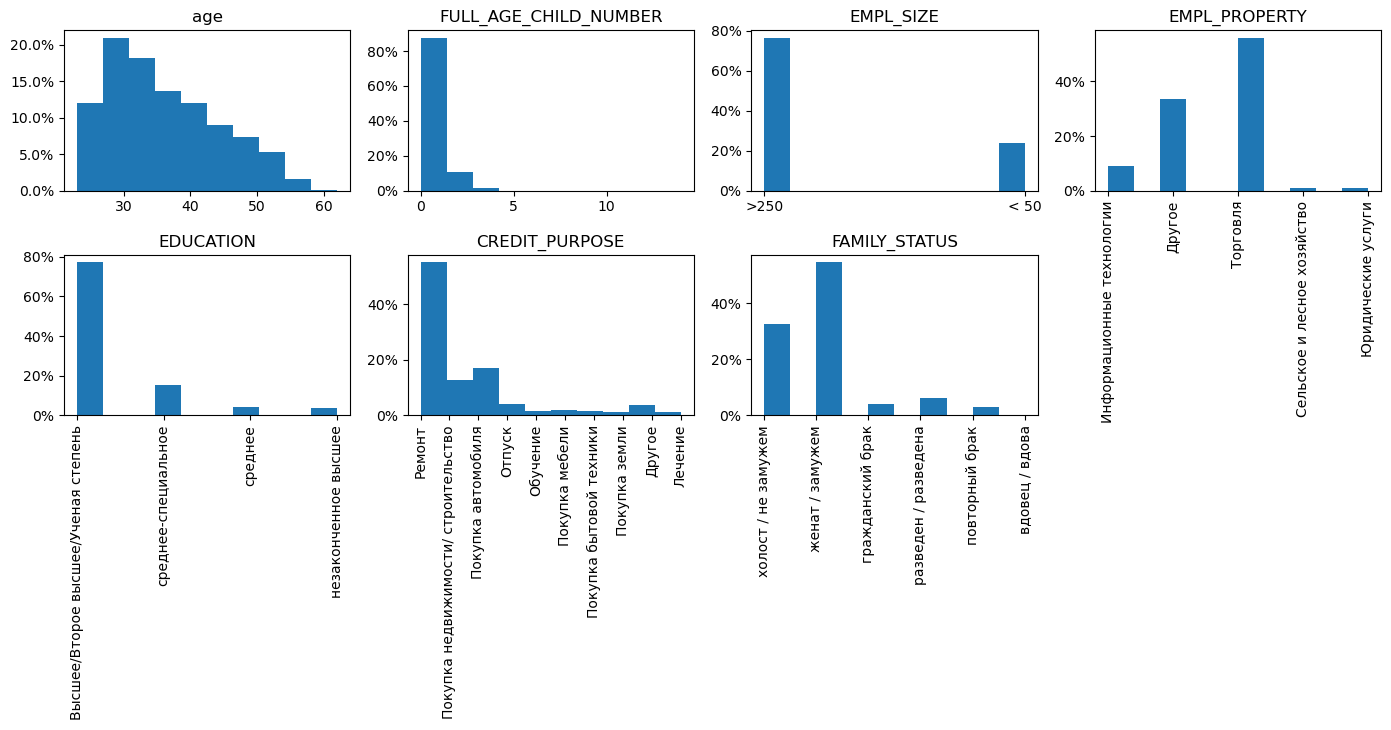

In [33]:
categories = ['age', 'FULL_AGE_CHILD_NUMBER', 'EMPL_SIZE', 'EMPL_PROPERTY', 'EDUCATION', 'CREDIT_PURPOSE', 'FAMILY_STATUS']

i = 1

plt.figure(figsize = (17, 5))
for category in categories:
    plt.subplot(2, int(len(categories)/2 + 1), i)
    plt.subplots_adjust(hspace=0.4)
    if i > 3:
        plt.xticks(rotation=90)
    plt.hist(data[category], weights=np.ones(data.shape[0]) / data.shape[0])
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.title(category)
    i += 1

этими графиками я хотела показать, что проблема наших данных в слишком высокой однородности. то есть у нас больше половины клиентов в данных имеют возраст от 30 до 40 лет, имеют высшее образование, работают в торговле, зарабатывают больше 250 тысяч и берут деньги на ремон. будет сложно делать кластеризацию

у нас очень много числовых признаков и все их посмотреть мы не сможем, возьмем только парочку основных, которые, кажется, больше всего интересны при решении стоит ли выдавать кредит человеку:

- DTI – отношение долга к доходам
- avg_num_delay – среднее количество задержки в днях
- all_credits – количество кредитов

будем смотреть зависимость этих переменных от пола, возраста, уровня образования и должности

In [34]:
def print_plots(category):
    plt.figure(figsize = (18, 10))
    plt.title(category)

    plt.subplot(2, 3, 1)
    sns.histplot(data[category])

    categories = ['age', 'SEX', 'EDUCATION', 'EMPL_TYPE']
    for i in range(4):
        if i == 0:
            plt.subplot(2, 2, 2)
        else:
            plt.subplot(2, 3, 3+i)
        plt.xticks(rotation=90)
        sns.boxplot(x=categories[i], y=category, data=data)

смотрим сначала отношение долга к доходам

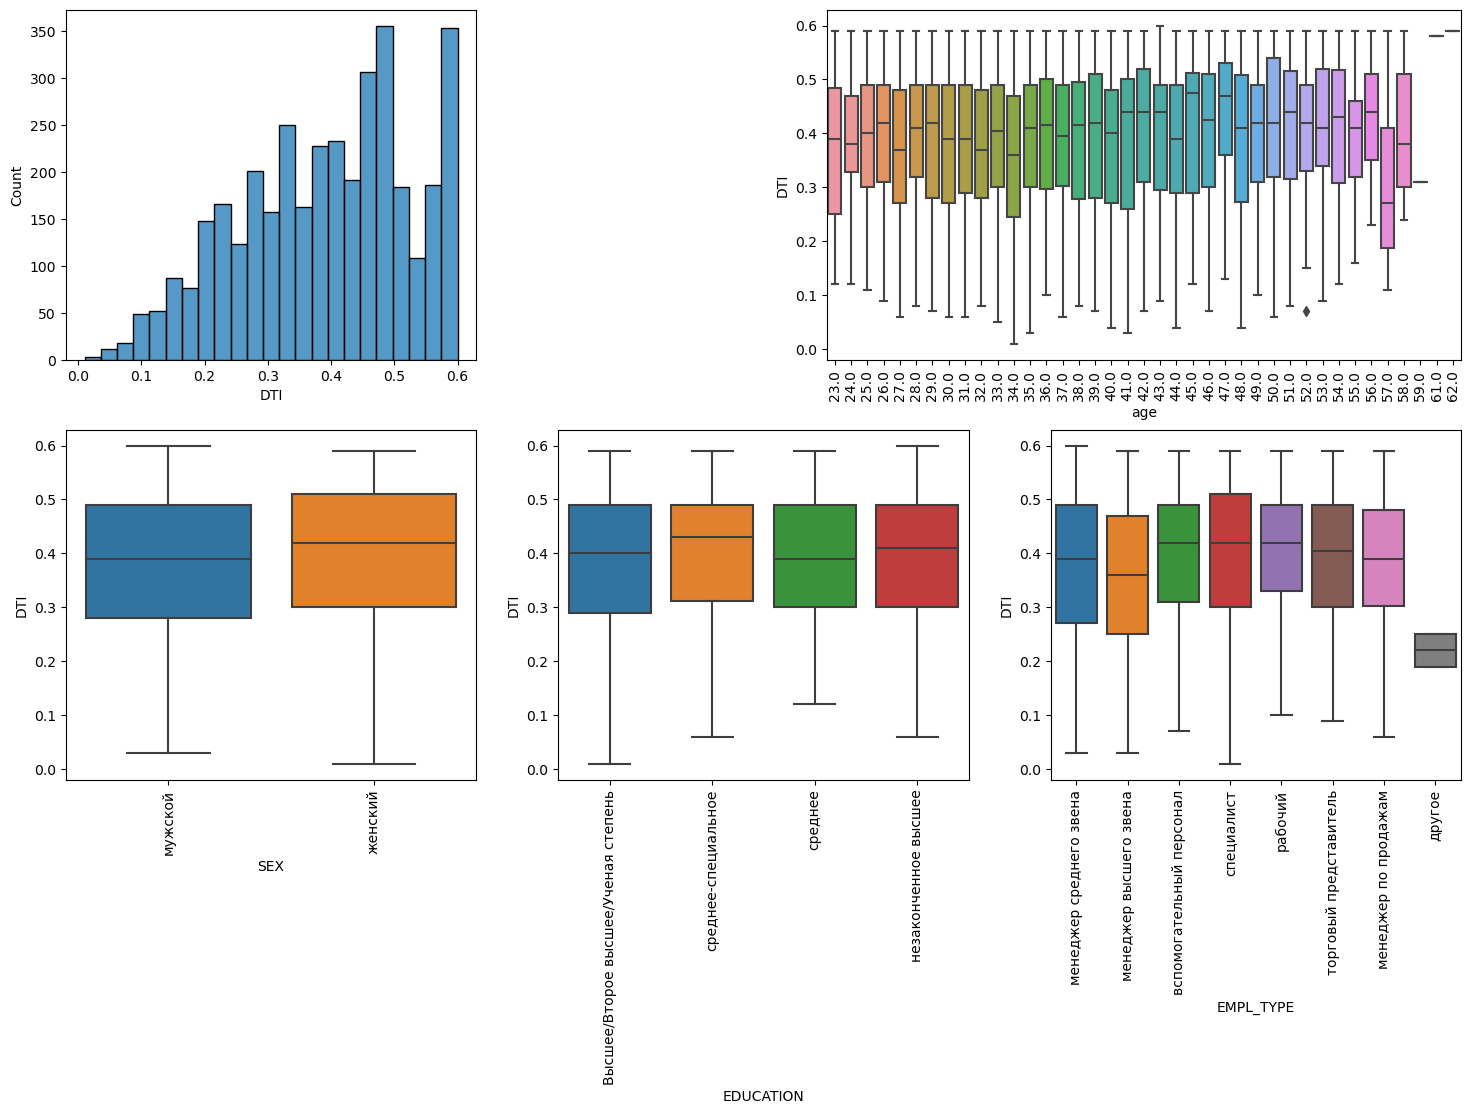

In [35]:
print_plots('DTI')

теперь среднее количество задержки по оплате кредита в днях

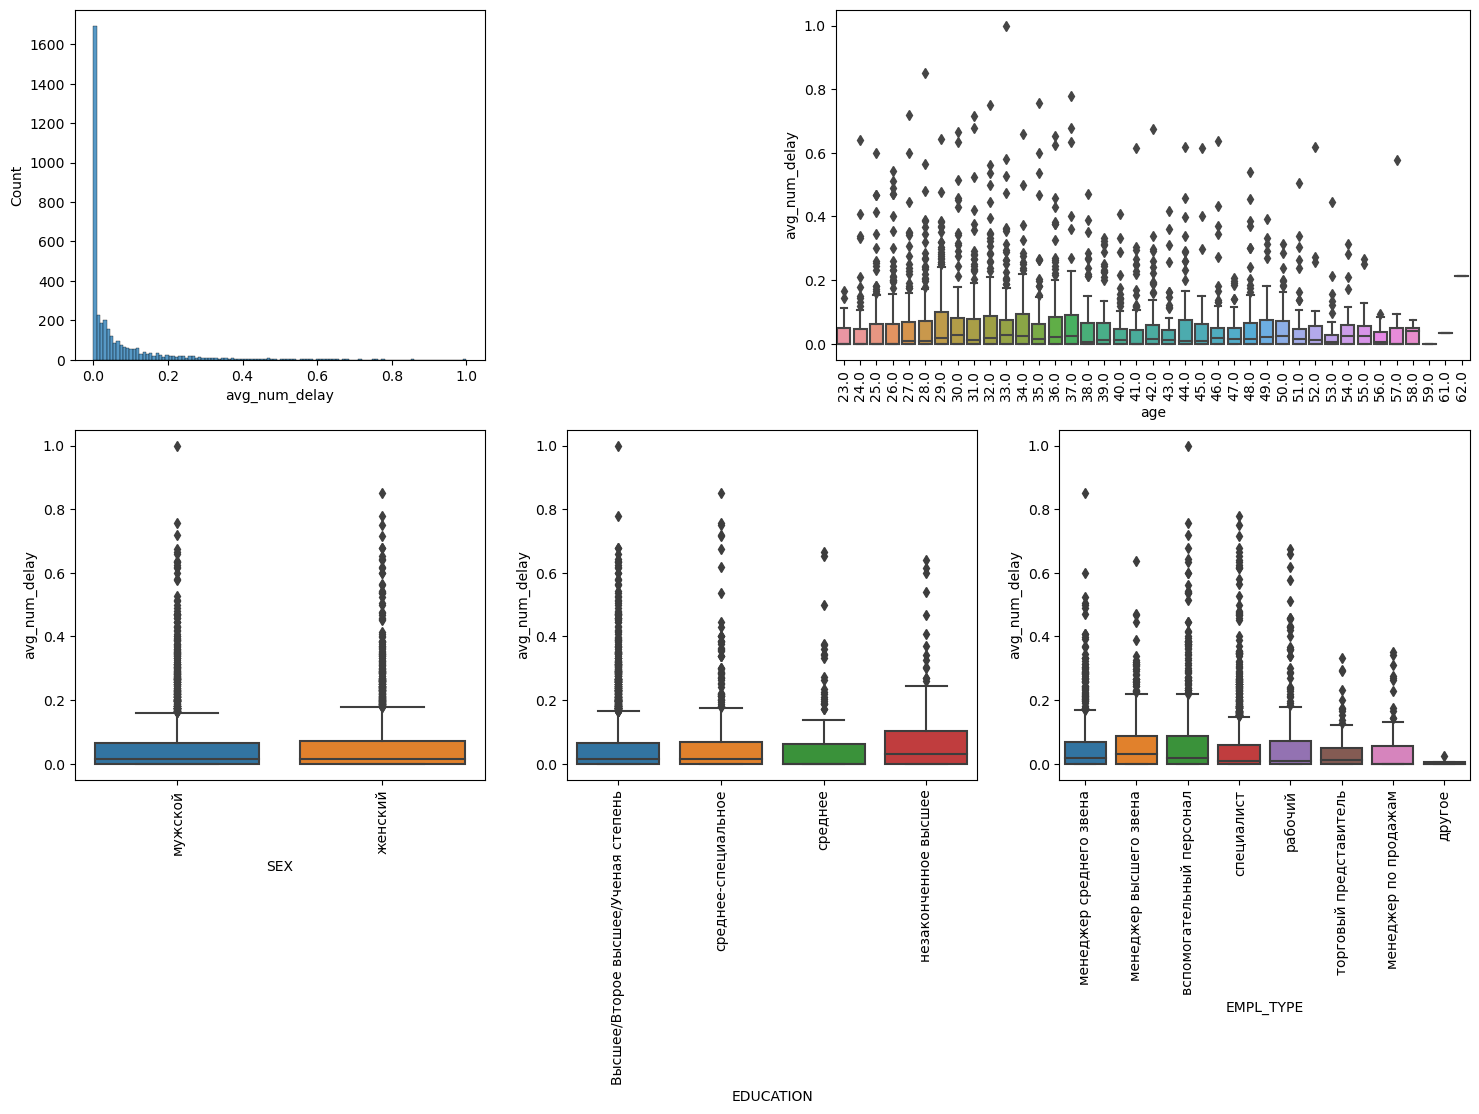

In [36]:
print_plots('avg_num_delay')

как мы можем заметить, большинство записей этого признака равны нулю, но у него очень большой хвост в распределении

теперь смотрим количество кредитов у обратившихся

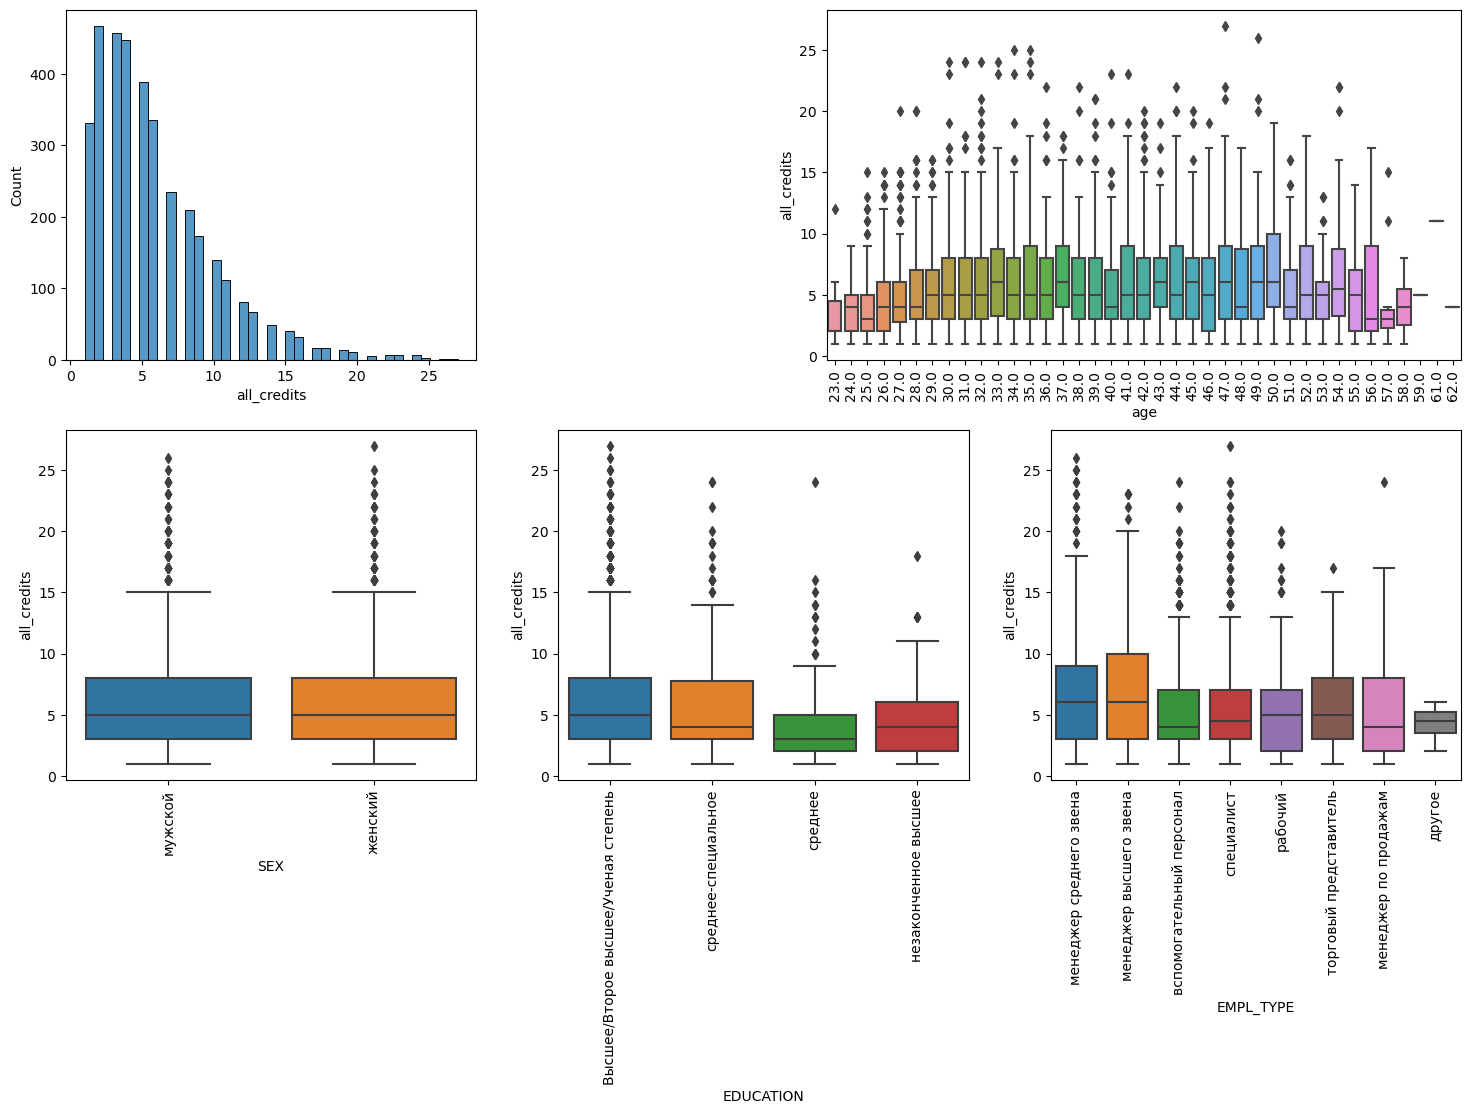

In [37]:
print_plots('all_credits')

ну и теперь посмотрим самые популярные значения по признакам, чтобы предварительно представить портрет самого популярного клиента, желающего взять кредит в нашем банке

In [38]:
print('rows:', data.shape[0], '\n')

for column in data.columns:
    if column != 'ID':
        print(column, ': ', data[column].value_counts().idxmax(), sep='', end='; ')

rows: 3646 

INCOME_BASE_TYPE: Поступление зарплаты на счет; CREDIT_PURPOSE: Ремонт; INSURANCE_FLAG: 1; DTI: 0.59; SEX: мужской; FULL_AGE_CHILD_NUMBER: 0; DEPENDANT_NUMBER: 0; EDUCATION: Высшее/Второе высшее/Ученая степень; EMPL_TYPE: специалист; EMPL_SIZE: >250; BANKACCOUNT_FLAG: 0.0; Period_at_work: 6.0; age: 29.0; EMPL_PROPERTY: Торговля; EMPL_FORM: ООО; FAMILY_STATUS: женат / замужем; max90days: 1.0; max60days: 0.0; max30days: 0.0; max21days: 0.0; max14days: 0.0; avg_num_delay: 0.0; if_zalog: 0.0; num_AccountActive180: 0.0; num_AccountActive90: 0.0; num_AccountActive60: 0.0; Active_to_All_prc: 0.5; numAccountActiveAll: 1.0; numAccountClosed: 1.0; sum_of_paym_months: 30.0; all_credits: 2.0; Active_not_cc: 1.0; own_closed: 0.0; min_MnthAfterLoan: 3.0; max_MnthAfterLoan: 89.0; dlq_exist: 1.0; thirty_in_a_year: 0.0; sixty_in_a_year: 0.0; ninety_in_a_year: 0.0; thirty_vintage: 0.0; sixty_vintage: 0.0; ninety_vintage: 0.0; 

из оставшихся 3646 строчек мы получаем портрет нашего клиента: 
- женатый мужчина без детей и иждивенцев
- 29 лет
- специалист, зарабатывает в торговой сфере с организационно-правовой формой ООО больше 250 тысяч рублей 
- с высшим образованием
- берет кредит на ремонт 
- страхует его, но без залога

<AxesSubplot:>

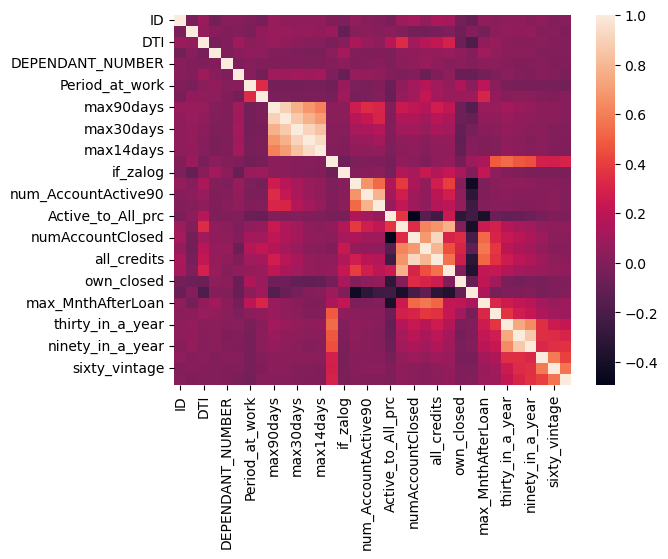

In [39]:
correlation = data.corr()
sns.heatmap(correlation)

по корреляционной матрице выше мы можем сделать еще несколько выводов по данным: 
- очень сильно зависят друг от друга признаки max90days, max30days, max14days. и это неудивительно, потому что на самом деле параметр max90days хранит в себе информацию и о max14days, ведь это количество запросов в бюро кредитных историй за последние N дней. то есть если обратились 1 раз за последние 14, то как минимум 1 раз обратились и за последние 90 дней и тд
- аналогичное встречается и в просрочках
- корреляция, близкая к 0 встречается в параметре "минимальное количество месяцев, которое прошло с момета взятия прошлого кредита" с параметрами вида "количество открытых/закрытых счетов", "количество кредитов" и тд. что тоже очень логично, ведь чем больше у нас открытых счетов и количество кредитов, тем с большей вероятностью последний кредит быть взят совсем недавно

кажется, мы уже со всех сторон исследовали данные и теперь можем приступать к кодированию категориальных признаков (где не просто флаги, а именно строчки с разными категориями), буду все делать с помощью one-hot encoder, потому что не хочу добавлять линейную зависимость от разных значений категориальных признаков. сразу еще добавляю нормализацию численных признаков

In [40]:
categories_to_transform = ['CREDIT_PURPOSE', 'EDUCATION', 'EMPL_TYPE', 'EMPL_FORM', 'FAMILY_STATUS', 
                            'EMPL_PROPERTY', 'INCOME_BASE_TYPE', 'EMPL_SIZE', 'SEX']

column_transformer = ColumnTransformer([
    # ('scaling', StandardScaler(), numerical),
    ('ohe', OneHotEncoder(), categories_to_transform),
], remainder='passthrough')

transformed = pd.DataFrame(column_transformer.fit_transform(data))
transformed.columns = [name.split('__')[1] for name in column_transformer.get_feature_names_out()]
print('columns added:', transformed.shape[1] - data.shape[1])
transformed


columns added: 38


,CREDIT_PURPOSE_Другое,CREDIT_PURPOSE_Лечение,CREDIT_PURPOSE_Обучение,CREDIT_PURPOSE_Отпуск,CREDIT_PURPOSE_Покупка автомобиля,CREDIT_PURPOSE_Покупка бытовой техники,CREDIT_PURPOSE_Покупка земли,CREDIT_PURPOSE_Покупка мебели,CREDIT_PURPOSE_Покупка недвижимости/ строительство,CREDIT_PURPOSE_Ремонт,...,own_closed,min_MnthAfterLoan,max_MnthAfterLoan,dlq_exist,thirty_in_a_year,sixty_in_a_year,ninety_in_a_year,thirty_vintage,sixty_vintage,ninety_vintage
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,66.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,49.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3.0,7.0,66.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,5.0,57.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,6.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,3.0,12.0,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,46.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3.0,16.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


итого получаем конечную витрину из 81 признака и 3646 строчек! ура :)

## часть 2. кластеризация
### метод k-means
у такого метода есть несколько плюсов: он отлично подходит для сегментации рынка, то есть для нашей задачи –– сегментации клиентов банка; в выборке очень много переменных, ее сложно будет сегментировать, например, деревом, а k-means все сделает за нас

есть проблема только в том, что методу надо руками задавать количество кластеров, которые можно определить с помощью метода локтя/инерции (что мы и будем делать, поглядим вплоть до 10), но это не может нам дать полного представления о том, какое количество кластеров –– оптимальное

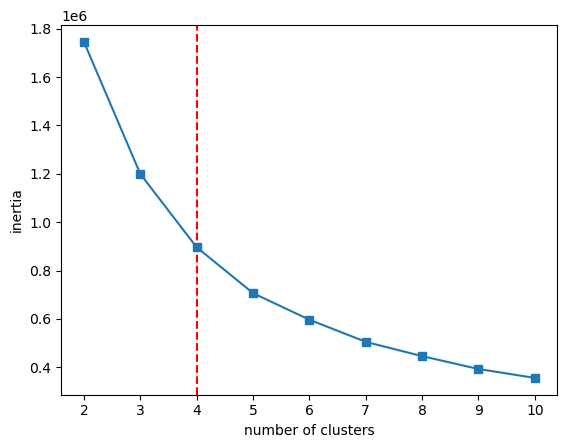

In [41]:
inertia = []
rg = range(2, 11)
for number_of_clusters in rg:
    kmeans = KMeans(n_clusters=number_of_clusters, random_state=42).fit(transformed)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.axvline(x=4, color='red', linestyle='dashed');

plt.plot(rg, inertia, marker='s');
plt.xlabel('number of clusters')
plt.ylabel('inertia');

как мы можем заметить по графику выше, явный перелом в изменении инерции происходит при выделении 3 кластеров

In [42]:
n_clusters = 3
clusters = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(transformed)

pd.DataFrame(clusters).value_counts()

2    1307
0    1235
1    1104
dtype: int64

замечу, что у нас кластеры получились примерно одинакового размера, что очень круто

In [43]:
categorical = [column for column in transformed.columns if column not in numerical and column != 'ID']

def print_clusters(df, n_clusters, clusters):
    final = pd.DataFrame(columns=[*map(str, range(1, n_clusters+1))])
    for i in range(n_clusters):
        current_cluster = df.loc[clusters == i]
        value = list(current_cluster[categorical].median()) + list(current_cluster[numerical].mean())
        final[str(i+1)] = value 
    final.index = categorical + numerical
                
    display_html(final[:40].style.set_table_attributes("style='display:inline'")._repr_html_() +
                    final[40:].style.set_table_attributes("style='display:inline'")._repr_html_(), raw=True)

print_clusters(transformed, n_clusters, clusters)

,1,2,3
CREDIT_PURPOSE_Другое,0.000000,0.000000,0.000000
CREDIT_PURPOSE_Лечение,0.000000,0.000000,0.000000
CREDIT_PURPOSE_Обучение,0.000000,0.000000,0.000000
CREDIT_PURPOSE_Отпуск,0.000000,0.000000,0.000000
CREDIT_PURPOSE_Покупка автомобиля,0.000000,0.000000,0.000000
CREDIT_PURPOSE_Покупка бытовой техники,0.000000,0.000000,0.000000
CREDIT_PURPOSE_Покупка земли,0.000000,0.000000,0.000000
CREDIT_PURPOSE_Покупка мебели,0.000000,0.000000,0.000000
CREDIT_PURPOSE_Покупка недвижимости/ строительство,0.000000,0.000000,0.000000
CREDIT_PURPOSE_Ремонт,1.000000,1.000000,1.000000


я не буду здесь и далее при рассмотрении результатов кластеризации как-то брать состоит ли в браке человек или нет, какое у него образование, на что он берет кредит. у нас данные, как я уже упомянула выше, довольно однородные, поэтому кластеры отличаются не этим. будем их отличать больше по числовым признакам

итого с помощью метода k-means у нас получилось три кластера:

- первый кластер: карьеристка

женщина, есть просрочка. больше всех работает и нет совершеннолетних детей, нет иждивенцев. больше всех платит по кредиту на данный момент и в целом закрыла много кредитов за всю историю. берет их часто

главная наша цель: удержание такого клиента, потому что он прибыльный, берет кредиты часто и на суммы побольше.

- второй кластер: мамочка

женщина, есть просрочка. меньше всех работает, больше всех иждивенцев и совершеннолетних детей. средний возраст чуть выше всех остальных. адекватное отношения долга к доходам, но просрачивает платежи по кредитам побольше остальных. 

такой категории клиентов стоит выдавать кредит под немного увеличенный процент, потому что высоки риски просрочки. 

- третий кластер: бережливый

мужчина, скорее есть совершеннолетние дети и меньше всего вероятность наличия иждивенцев. редко просрачивает и берет кредиты на суммы меньшие, чем другие клиенты, хотя платежеспособность у него высокая. берет кредиты мало и редко

цель нашей работы с такой категорией клиентов –– привлечение. у них есть деньги и возможности платит по кредитам, их закрывать, они довольно бережно относятся к своим деньгам. стоит давать им более привлекательные условия и повышать чеки

### DBSCAN
метод очень хорошо работает для данных странной формы. сложно представить, какой именно формы наши данные, но k-means крутой для данных более шарообразных, так что мы по факту попробуем два метода, которые лучше для разных видов данных, что снизит вероятность нашей ошибки. также я выбрала этот метод, потому что он сам определяет количество кластеров, не нужно указывать это руками

сначала немного поисследуем, как вообще себя ведет алгоритм, ведь он зависит от нескольких параметров: esp и min_samples. эмпирическим путем я выяснила, что eps < 100 не имеет смысла, там практически все точки будут отдельно, так что рассмотрим зависимость процента аномалий от параметра eps. min_samples –– минимальное количество точек в кластере, я выставила 200, чтобы у нас кластеры были адекватными и их хоть как-то можно было бы интерпретировать

In [44]:
outlier_percentage = 1.

num_clusters = []
anomaly_percentage = []

# берем маленький эпсилон и начинаем увеличивать
eps = 100
eps_history = [eps]

while outlier_percentage > 0.1:    
    model = DBSCAN(eps=eps, min_samples=250).fit(transformed)
    
    labels = model.labels_
    num_clusters.append(len(np.unique(labels))-1)
    labels = np.array([1 if label == -1 else 0 for label in labels])
    
    # считаем текущий процент "шума"
    outlier_percentage = sum(labels==1) / len(labels)    
    eps += 50 
    eps_history.append(eps)
    anomaly_percentage.append(outlier_percentage)

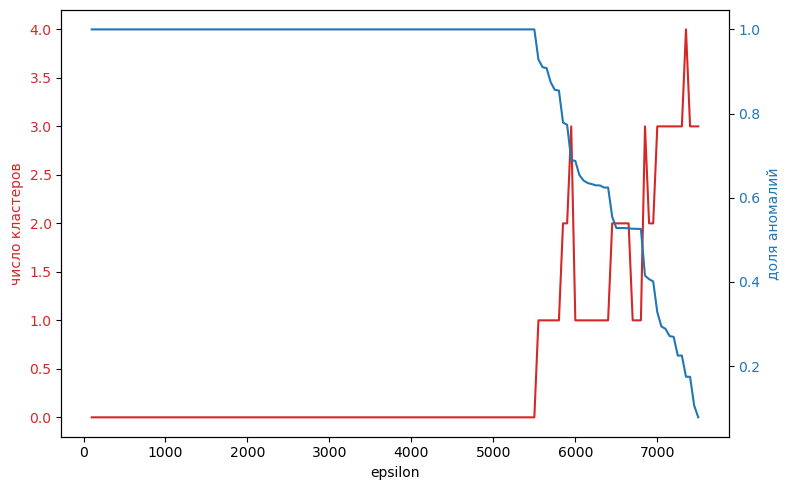

In [45]:
iterations = eps_history[:-1]

fig, ax1 = plt.subplots(figsize=(8,5))
color = 'tab:red'
ax1.set_xlabel('epsilon')
ax1.set_ylabel('число кластеров', color=color)
ax1.plot(iterations, num_clusters, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # инициализация второй оси в соотвествии с размером первой

color = 'tab:blue'
ax2.set_ylabel('доля аномалий', color=color)
ax2.plot(iterations, anomaly_percentage, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.show()

судя по графику, стоит выставить eps около 7500

In [46]:
clustering = DBSCAN(eps=7500, min_samples=250).fit(transformed)

labels = clustering.labels_
print('доля аномалий:', np.sum(labels == -1)/transformed.shape[0] * 100)
print('количество кластеров:', np.unique(labels)[-1] + 1)

доля аномалий: 7.816785518376303
количество кластеров: 3


в таком случае получается около 8 процентов аномалий, что, как мне кажется, довольно разумно и должно соответствовать реальности.

In [47]:
print_clusters(transformed, 3, labels)

,1,2,3
CREDIT_PURPOSE_Другое,0.000000,0.000000,0.000000
CREDIT_PURPOSE_Лечение,0.000000,0.000000,0.000000
CREDIT_PURPOSE_Обучение,0.000000,0.000000,0.000000
CREDIT_PURPOSE_Отпуск,0.000000,0.000000,0.000000
CREDIT_PURPOSE_Покупка автомобиля,0.000000,0.000000,0.000000
CREDIT_PURPOSE_Покупка бытовой техники,0.000000,0.000000,0.000000
CREDIT_PURPOSE_Покупка земли,0.000000,0.000000,0.000000
CREDIT_PURPOSE_Покупка мебели,0.000000,0.000000,0.000000
CREDIT_PURPOSE_Покупка недвижимости/ строительство,0.000000,0.000000,0.000000
CREDIT_PURPOSE_Ремонт,1.000000,1.000000,1.000000


итого с помощью метода DBSCAN у нас получилось три примерно таких же кластера, как и в k-means: 
- бережливый, которого надо привлечь; 
- мамочка (папочка в данном случае, но это не очень важно), просрачивающая много кредитов –– дает кредиты под чуть больший процент, чтобы нивелировать риски; 
- карьеристка, которая много платит по кредитам –– такого клиента нужно удерживать.

то есть по итогам двух методов кластеризации мы выявили примерно одинаковые по своим привычкам кластеры, что только подтверждает корректность наших выводов. ура!